# Prepare the Arecibo data

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
import glob

In [27]:
datadir = "/mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/data/data_Arecibo/Bursts_npys/"
resdir = "/mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/data/data_Arecibo/"

### Explore the data

In [29]:
#Load the data from a specific burst
file = "57607.53162420549.npy"
data = np.load(datadir + file, allow_pickle=True)

The data contains 64 channels and 2432 bins


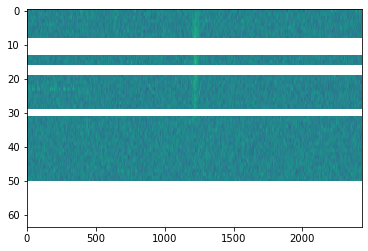

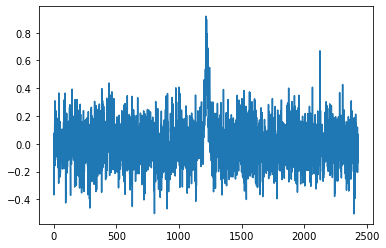

In [30]:
# This is how the masked data looks
plt.imshow(data,aspect='auto')
print(f"The data contains {data.shape[0]} channels and {data.shape[1]} bins")

# This plots only the non-masked data 
plt.figure()
plt.plot(np.mean(data, axis=0))
plt.show()

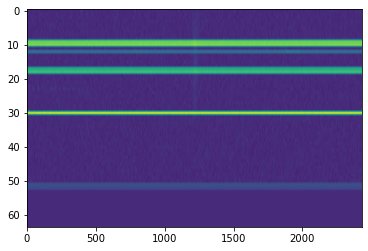

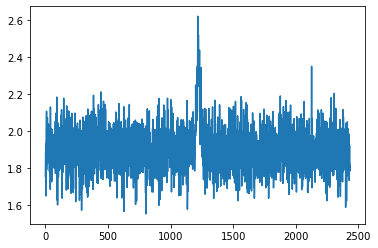

In [31]:
# This is how all the data looks. The RFI is not masked yet 
plt.imshow(data.data,aspect='auto')

# The y-values in the timeseries are therefor higher 
plt.figure()
plt.plot(np.mean(data.data, axis=0))
plt.show()

To continue, we want to use the masked data. We don't want our timeseries to be contaminated with RFI.  Currently, the data still has varying mean and standard deviation per channel and bin. Next, we want to normalize the data to get it in S/N values. For this we will calculate the mean and standard deviation of the noise (off-burst region). We substract the mean of the data and divide by the standard deviation. 

Text(0.5, 1.0, 'Normalized time series of 57607.53162420549.npy')

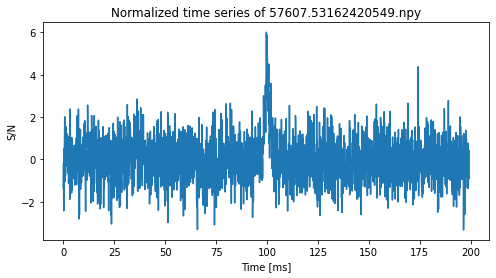

In [32]:
# Collapse the dynamic spectrum to a time series/profile
profile = np.mean(data,axis=0)

# Normalize the burst to get in S/N
noise_std = np.std(profile[0:750])
noise_mean = np.mean(profile[0:750])
norm_prof = (profile - noise_mean) / noise_std

# Get time array 
dt = 0.08192 # in ms (81.92 us resolution)
time = np.arange(0, dt*len(norm_prof), dt)

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(time, norm_prof)
ax.set_ylabel("S/N")
ax.set_xlabel("Time [ms]")
ax.set_title(f"Normalized time series of {file}")

### Shorten the lightcurve 
We first extract the maximum burst width in the Arecibo data. This we use as a benchmark to cut of away the noise. The peak of the burst is in the middle of the array. In case of multiple bursts, the first burst will be in the middle. 

Regarding the table content: 
These times are dynamical times (TDB), corrected to the Solar System Barycenter to infinite frequency assuming a dispersion measure of 560.5 pc\,cm$^{-3}$ and dispersion constant of 1/(2.41$\times$10$^{-4}$ ) MHz$^{2}$\,pc$^{-1}$\,cm$^{3}$\,s.
 $^{b}$ We estimate a conservative $25$\,percent uncertainty on these measurements due to uncertainty in the SEFD of Arecibo.

In [33]:
table = "/mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/data/data_Arecibo/stac1960_supplemental_file.txt"
tab = Table.read(table, format='latex', guess=False).to_pandas()
tab.head()

,Burst ID,TOA,Width (ms),Bandwidth (MHz),$f_{\rm{high (MHz)}$,$f_{\rm{low (MHz)}$,Fluence (Jy ms),Energy (erg),Group
0,1,57364.204636,0.68 + 0.05,> 546,> 1730,1184,0.08,4.0 \times 10 ^ 37,HEB
1,2,57506.802409,4.7 + 0.3,> 381,> 1730,1349,0.38,1.3 \times 10 ^ 38,LEB
2,3,57510.807219,2.27 + 0.09,> 546,> 1730,1184,0.29,1.4 \times 10 ^ 38,HEB
3,4,57510.819154,2.2 + 0.3,> 305,> 1730,1425,0.11,2.9 \times 10 ^ 37,LEB
4,5,57510.826409,3.4 + 0.2,> 419,> 1730,1311,0.27,1.0 \times 10 ^ 38,LEB


In [34]:
# Get the average and max widths of the bursts 
widths = []
uncertainties = []

for row in tab["Width (ms)"]:
    val = row.split("+")
    width = float(val[0])
    uncertainty = float(val[1])
    widths.append(width)
    uncertainties.append(uncertainty)

print(f"Average width {np.mean(widths)} +/- {np.mean(uncertainties)} ms \nMaximum width {max(widths)} ms +/- {max(uncertainties)} ms")

Average width 4.6712552301255235 +/- 0.7349581589958157 ms 
Maximum width 26.0 ms +/- 5.0 ms


In [35]:
def cut_noise(time, profile, max_bc_width):
    """Cut away noise in the FRB lightcurve of Arecibo by only keeping two boxcar widths 
    from the peak of the FRB (middle of the lightcurve)."""

    # Get profile and time of the FRB peak which is always in the middle
    idx_peak_prof = int((len(profile)-1)/2)
    peak_time = time[idx_peak_prof]
    
    # Get shortenend lightcurve keeping only one boxcar width on either side of the peak
    time_cut = time[(time > peak_time - max_bc_width) * (time < peak_time + max_bc_width)] 
    prof_cut = profile[(time > peak_time - max_bc_width) * (time < peak_time + max_bc_width)]

    return time_cut, prof_cut

In [36]:
# Keep 2 times the maximum burst width on either side of the burst peak
max_width = 2*31.0 # 26 +/- 5.0 ms

# Cut away noise in the lightcurve
time_cut, prof_cut = cut_noise(time, norm_prof, max_width)

Text(0.5, 1.0, 'Normalized and cut time series of 57607.53162420549.npy')

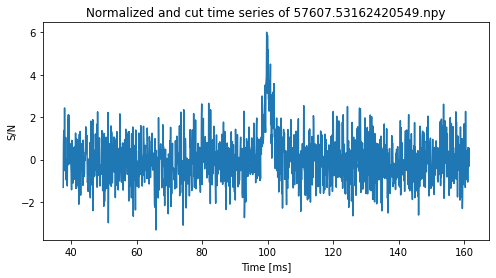

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(time_cut, prof_cut)
ax.set_ylabel("S/N")
ax.set_xlabel("Time [ms]")
ax.set_title(f"Normalized and cut time series of {file}")

### Get all data normalized and shortenend 
All bursts from Arecibo have the same about of bins (2432) and the (first) burst is in the middle. Therefore we can hardcode the place where we determine the mean and standard deviation of the noise. 

In [ ]:
def normalize(profile: np.ma.masked_array):
    """Normalize the time series/profile of the Arecibo to get data in S/N
    Return: normalized profile
    """
    noise_std = np.std(profile[0:750])
    noise_mean = np.mean(profile[0:750])
    norm_prof = (profile - noise_mean) / noise_std
    return noise_std, norm_prof

In [28]:
# Save all the Arecibo numpy arrays as .dat files normalized and cut

for file in glob.glob(f"{datadir}/*.npy"):
    #Load the data from a specific burst
    data = np.load(file, allow_pickle=True)

    # Collapse the dynamic spectrum to a time series/profile and normalize
    profile = np.mean(data,axis=0)
    noise_std, norm_prof = normalize(profile)
    
    # Get time array 
    dt = 0.08192 # in ms (81.92 us resolution)
    time = np.arange(0, dt*len(norm_prof), dt)

    # Keep 2 times the max burst width (26 +/- 5.0 ms) on either side of the burst peak
    max_width = 2*31.0

    # Cut away noise in the lightcurve
    time_cut, prof_cut = cut_noise(time, norm_prof, max_width)

    # Convert into .dat file with columns time, snr and snr error 
    df = pd.DataFrame(time_cut, columns=['time'])
    df['snr'] = prof_cut 
    df['snr_err'] = noise_std
    position = file.index('.')
    
    filename = file.split("/")[-1]
    filename = filename.removesuffix(".npy")

    df.to_csv(f"{datadir}/{filename}.dat", sep=" ", header=False, index=False) # this overwrites files with same name